<a href="https://colab.research.google.com/github/vdlcruz670/SPICE-2024/blob/main/waveheight_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wave Height Predictions with ARIMA

## Introduction


The goal is to use machine learning to build a time-series model that can be used to predict wave height measurements for the selected buoy area. We'll be building an ARIMA model.

The dataset comes from the [National Data Buoy Center](https://www.ndbc.noaa.gov/).

The buoy used for this example is Buoy #[51101](https://www.ndbc.noaa.gov/station_page.php?station=51101), which is located Northwest of Kauai, Hawaii.


### ARIMA

You can read this article for more info.
https://medium.com/analytics-vidhya/arima-for-dummies-ba761d59a051


# Imports and Data

## Imports

The below code chunk loads in all your packages and imports, make sure to run this every time you start your session.

Packages include all the tools you need to successfully run all your code and analysis.

In [ ]:
!pip install statsmodels
!pip install pmdarima

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn import linear_model

from pandas import to_datetime
import datetime
from datetime import datetime
import pandas as pd
import pmdarima as pm
import itertools
import warnings
import matplotlib.pyplot as plt
from matplotlib import pyplot

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict

warnings.filterwarnings('ignore')
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.6 MB/s eta 0:00:00


## Data

To load in our data, we use the pandas function read_csv to get the data directly from the National Data Buoy Center and are assigning it to the variable called *df1*.

A variable is a place/object where we can store information.

In [ ]:
df1 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2017.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data

In [64]:
df_23 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2023.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data
df_22 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2022.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data
df_21 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2021.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data
df_20 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2020.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data
df_19 = pd.read_csv('https://www.ndbc.noaa.gov/view_text_file.php?filename=51101h2019.txt.gz&dir=data/historical/stdmet/', delimiter= '\s+', index_col=False) # reading in the data

In [69]:
df1.head() # looking at first 5 rows

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,mi,ft
1,2023,01,01,00,00,191,4.1,5.4,99.00,99.00,99.00,999,1016.4,24.1,24.3,999.0,99.0,99.00
2,2023,01,01,00,10,188,4.0,5.3,2.11,12.90,9.09,302,1016.4,24.1,24.3,999.0,99.0,99.00
3,2023,01,01,00,20,191,3.6,4.8,99.00,99.00,99.00,999,1016.4,24.1,24.3,999.0,99.0,99.00
4,2023,01,01,00,30,195,4.0,5.2,99.00,99.00,99.00,999,1016.2,24.1,24.4,999.0,99.0,99.00


# Exploring the Data

For this project, the target variable we'll focus on is WVHT (wave height in meters).

In [ ]:
df1.info() # looking at basic information about your variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8645 entries, 0 to 8644
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   #YY     8645 non-null   object
 1   MM      8645 non-null   object
 2   DD      8645 non-null   object
 3   hh      8645 non-null   object
 4   mm      8645 non-null   object
 5   WDIR    8645 non-null   object
 6   WSPD    8645 non-null   object
 7   GST     8645 non-null   object
 8   WVHT    8645 non-null   object
 9   DPD     8645 non-null   object
 10  APD     8645 non-null   object
 11  MWD     8645 non-null   object
 12  PRES    8645 non-null   object
 13  ATMP    8645 non-null   object
 14  WTMP    8645 non-null   object
 15  DEWP    8645 non-null   object
 16  VIS     8645 non-null   object
 17  TIDE    8645 non-null   object
dtypes: object(18)
memory usage: 1.2+ MB


From the above information, we learn that the dataset currently has 8,645 rows and 18 columns.

In [ ]:
df1.head() # looking at the first five rows of your data

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,mi,ft
1,2016,12,31,23,50,52,5.3,7.5,1.93,9.09,6.53,50,1016.1,21.2,24.5,999.0,99.0,99.00
2,2017,01,01,00,50,52,4.6,6.4,1.97,10.00,6.52,57,1016.0,21.3,24.5,999.0,99.0,99.00
3,2017,01,01,01,50,31,6.8,8.5,2.02,10.00,6.52,52,1016.2,21.3,24.5,999.0,99.0,99.00
4,2017,01,01,02,50,32,6.2,8.7,2.08,9.09,6.77,48,1016.6,21.4,24.5,999.0,99.0,99.00


In [ ]:
df1.tail() # looking at the last five rows of your data

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
8640,2017,12,31,18,50,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.00
8641,2017,12,31,19,50,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.00
8642,2017,12,31,20,50,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.00
8643,2017,12,31,21,50,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.00
8644,2017,12,31,22,50,134,5.6,7.1,1.59,13.79,6.74,320,1019.4,22.7,23.6,999.0,99.0,99.00


Let's look to see if we have NA values (missing values) in our dataset.

We're making another variable called *na_values*, to see if any column has NA values.

In [92]:
na_values = pd.DataFrame(df_21.isna().sum()) # looking at na values
na_values # typing in the variable name prints it out for you

,0
#YY,0
MM,0
DD,0
hh,0
mm,0
WDIR,0
WSPD,0
GST,0
WVHT,0
DPD,0


In [76]:
print(len(df_23)) # checking how many rows the variable has
print(len(df_22))
print(len(df_21))
print(len(df_20))
print(len(df_19))

52523
52480
51485
52178
52123


In [99]:
df_22

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,#yr,mo,dy,hr,mn,degT,m/s,m/s,m,sec,sec,degT,hPa,degC,degC,degC,mi,ft
1,2022,01,01,00,00,112,9.4,12.1,99.00,99.00,99.00,999,1004.4,23.4,24.3,22.3,99.0,99.00
2,2022,01,01,00,10,110,8.6,10.8,99.00,99.00,99.00,999,1004.2,23.4,24.3,22.3,99.0,99.00
3,2022,01,01,00,20,115,9.8,13.1,99.00,99.00,99.00,999,1004.0,23.6,24.2,22.4,99.0,99.00
4,2022,01,01,00,30,108,10.3,12.6,99.00,99.00,99.00,999,1003.9,23.5,24.2,22.5,99.0,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52475,2022,12,31,23,10,197,4.0,5.1,2.27,12.9,8.93,296,1017.4,24.1,24.2,999.0,99.0,99.0
52476,2022,12,31,23,20,198,4.1,5.0,99.0,99.0,99.0,999,1017.1,24.1,24.2,999.0,99.0,99.0
52477,2022,12,31,23,30,195,3.9,5.4,99.0,99.0,99.0,999,1016.9,24.0,24.2,999.0,99.0,99.0
52478,2022,12,31,23,40,192,4.0,5.5,2.23,12.12,8.82,303,1016.7,24.0,24.3,999.0,99.0,99.0


# Data Cleaning

We need to clean our data to help our analysis run smoother and format it properly.

We'll be deleting the first two rows of our dataset as it just repeats the column names and has a row from 2016, and assigning it to a new variable called df1_clean.

In [44]:
df1_clean = df1.iloc[2:] # dropping the first two rows
df1_clean

,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
2,2017,01,01,00,50,52,4.6,6.4,1.97,10.00,6.52,57,1016.0,21.3,24.5,999.0,99.0,99.00
3,2017,01,01,01,50,31,6.8,8.5,2.02,10.00,6.52,52,1016.2,21.3,24.5,999.0,99.0,99.00
4,2017,01,01,02,50,32,6.2,8.7,2.08,9.09,6.77,48,1016.6,21.4,24.5,999.0,99.0,99.00
5,2017,01,01,03,50,26,5.3,7.0,1.95,9.09,6.48,63,1016.8,21.2,24.4,999.0,99.0,99.00
6,2017,01,01,04,50,39,5.2,7.0,1.69,10.00,6.53,63,1017.0,21.2,24.4,999.0,99.0,99.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,2017,12,31,18,50,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.00
8641,2017,12,31,19,50,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.00
8642,2017,12,31,20,50,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.00
8643,2017,12,31,21,50,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.00


As you can see, there are separate columns for year, month, day, hour, and minute. We need to combine these columns in order to create a single datetime column.

In [45]:
df1_clean = df1_clean.astype({'#YY' : str, 'MM' : str, 'DD' : str, 'hh' : str, 'mm' : str}) # converting these columns to a string data type
df1_clean['Date'] = df1_clean['#YY'] + '-' + df1_clean['MM'] + '-' + df1_clean['DD'] + ' ' + df1_clean['hh'] + ':' + df1_clean['mm'] # combining all the datetime info into a Date column
df1_clean = df1_clean.drop(columns=['#YY','MM','DD','hh','mm']) # deleting the old date and time columns
df1_clean

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,Date
2,52,4.6,6.4,1.97,10.00,6.52,57,1016.0,21.3,24.5,999.0,99.0,99.00,2017-01-01 00:50
3,31,6.8,8.5,2.02,10.00,6.52,52,1016.2,21.3,24.5,999.0,99.0,99.00,2017-01-01 01:50
4,32,6.2,8.7,2.08,9.09,6.77,48,1016.6,21.4,24.5,999.0,99.0,99.00,2017-01-01 02:50
5,26,5.3,7.0,1.95,9.09,6.48,63,1016.8,21.2,24.4,999.0,99.0,99.00,2017-01-01 03:50
6,39,5.2,7.0,1.69,10.00,6.53,63,1017.0,21.2,24.4,999.0,99.0,99.00,2017-01-01 04:50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.00,2017-12-31 18:50
8641,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.00,2017-12-31 19:50
8642,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.00,2017-12-31 20:50
8643,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.00,2017-12-31 21:50


Now we have one column with all the information we need. To move on, we need the data type for that column to be datetime format.

In [46]:
df1_clean['Date'] = pd.to_datetime(df1_clean['Date'])
df1_clean

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE,Date
2,52,4.6,6.4,1.97,10.00,6.52,57,1016.0,21.3,24.5,999.0,99.0,99.00,2017-01-01 00:50:00
3,31,6.8,8.5,2.02,10.00,6.52,52,1016.2,21.3,24.5,999.0,99.0,99.00,2017-01-01 01:50:00
4,32,6.2,8.7,2.08,9.09,6.77,48,1016.6,21.4,24.5,999.0,99.0,99.00,2017-01-01 02:50:00
5,26,5.3,7.0,1.95,9.09,6.48,63,1016.8,21.2,24.4,999.0,99.0,99.00,2017-01-01 03:50:00
6,39,5.2,7.0,1.69,10.00,6.53,63,1017.0,21.2,24.4,999.0,99.0,99.00,2017-01-01 04:50:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8640,114,5.9,7.0,1.39,13.79,6.72,316,1020.8,22.2,23.4,999.0,99.0,99.00,2017-12-31 18:50:00
8641,114,4.3,5.4,1.54,14.81,6.85,300,1021.3,22.6,23.4,999.0,99.0,99.00,2017-12-31 19:50:00
8642,132,5.3,6.9,1.60,14.81,7.17,323,1021.0,22.6,23.5,999.0,99.0,99.00,2017-12-31 20:50:00
8643,116,5.4,7.2,1.53,13.79,6.81,310,1020.5,22.6,23.5,999.0,99.0,99.00,2017-12-31 21:50:00


In [ ]:
df1_clean.info() # looking at updated info about our clean dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8644 entries, 1 to 8644
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   WDIR    8644 non-null   object        
 1   WSPD    8644 non-null   object        
 2   GST     8644 non-null   object        
 3   WVHT    8644 non-null   object        
 4   DPD     8644 non-null   object        
 5   APD     8644 non-null   object        
 6   MWD     8644 non-null   object        
 7   PRES    8644 non-null   object        
 8   ATMP    8644 non-null   object        
 9   WTMP    8644 non-null   object        
 10  DEWP    8644 non-null   object        
 11  VIS     8644 non-null   object        
 12  TIDE    8644 non-null   object        
 13  Date    8644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(13)
memory usage: 945.6+ KB


We see that the date column is a datetime data type, and the dataset is now 8,643 rows and 14 columns.

# ARIMA

## ARIMA Prep

In ARIMA, we're only going to be looking at two columns - the date and the WVHT columns (wave height is what we're trying to predict). We're going to select those two columns only and store it in a new variable called *arima_data*.

In [47]:
arima_data = df1_clean[['Date', 'WVHT']] # selecting columns
arima_data.head() # looking at first five rows of arima_data

,Date,WVHT
2,2017-01-01 00:50:00,1.97
3,2017-01-01 01:50:00,2.02
4,2017-01-01 02:50:00,2.08
5,2017-01-01 03:50:00,1.95
6,2017-01-01 04:50:00,1.69


Next, we want to set the date as the index (the row labels).

In [48]:
arima_data = arima_data.set_index('Date') # setting date column to index
arima_data

,WVHT
Date,
2017-01-01 00:50:00,1.97
2017-01-01 01:50:00,2.02
2017-01-01 02:50:00,2.08
2017-01-01 03:50:00,1.95
2017-01-01 04:50:00,1.69
...,...
2017-12-31 18:50:00,1.39
2017-12-31 19:50:00,1.54
2017-12-31 20:50:00,1.60


Let's try to see what our data looks like.

Our data represents wave heights in our selected buoy area for the year 2017.

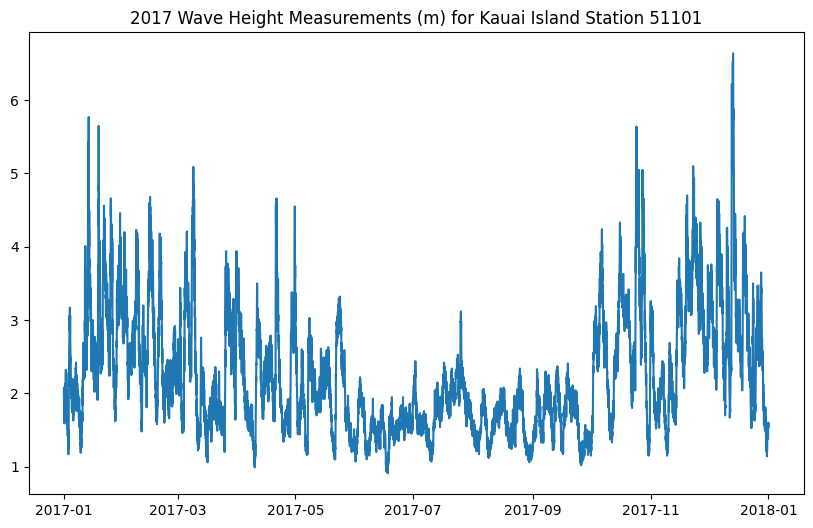

In [49]:
arima_data['WVHT'] = arima_data['WVHT'].astype(float) # changing the datatype for WVHT for a nicer look on the plot
plt.figure(figsize=(10,6)) # setting up the dimentions for our plot
plt.title('2017 Wave Height Measurements (m) for Kauai Island Station 51101') # setting up a title
plt.plot(arima_data['WVHT']) # plotting our data

## Splitting Data for Training and Testing

For supervised machine learning, it's common to split your data for training and testing.

We'll be splitting our data 80-20, meaning 80% of our data will be used to train our ARIMA model while we use the other 20% to test how well our model did.

The training data will be stored in a new variable called *arima_train* while the testing data will be stored in *arima_test*.

In [ ]:
arima_tts = arima_data['WVHT']
arima_train = arima_tts[:int(len(arima_data)*0.8)] # selecting 80% of arima_data for training
arima_test = arima_tts[int(len(arima_data)*0.8):] # selecting the last 20% of data for testing

Let's double check to make sure our train-test-split went smoothly (that the numbers add up).

In [ ]:
print(len(arima_train)) # printing the length of arima_train
print(len(arima_test)) # printing the length of arima_test
print(len(arima_data)) # arima_train + arima_test should equal arima_data

6915
1729
8644


## ARIMA Parameters and Testing for Stationarity

ARIMA models have 3 parameters (p, q, d):

- AR = p (found from pacf plot)
- MA = q (found from acf plot)
- The number of differencing = d

------

In order to determine d, we need to figure out if our data is stationary.

Stationary means that your data has a constant mean, variance, and covariance that is independent of time. We can test for stationarity using the Augmented Dickey Fuller (ADF) test.

If your data is **NOT** stationary, we would need to difference it.


In [ ]:
adf_test = adfuller(arima_data['WVHT']) # performing adf test
print('ADF Statistic: ', adf_test[0]) # printing results
print('P-value: ', adf_test[1])

ADF Statistic:  -7.141465457408021
P-value:  3.31570354059651e-10


If your p-value is > .05, your time series is not stationary.

If it is < .05, your time series is stationary.

Based on the p-value, our data is *not* stationary.

Because it is not stationary, we need to perform differencing (in order to figure out what the d parameter will be).

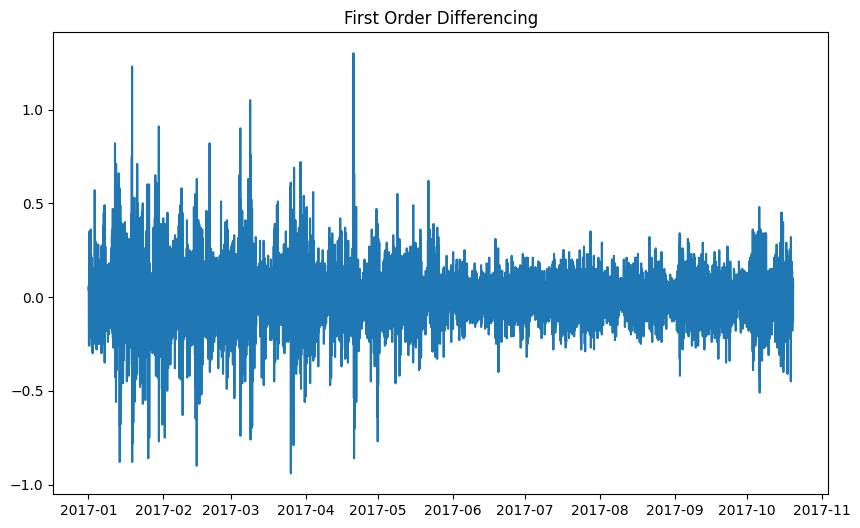

In [ ]:
arima_train_diff = arima_train.diff().dropna() # first order differencing

plt.figure(figsize=(10, 6)) # setting up plot size
plt.title('First Order Differencing')
plt.plot(arima_train_diff) # plotting differencing results

Since we performed differencing *once*, our d parameter will be equal to 1. Now let's figure out p and q using autocorrelation and partial correlation plots.

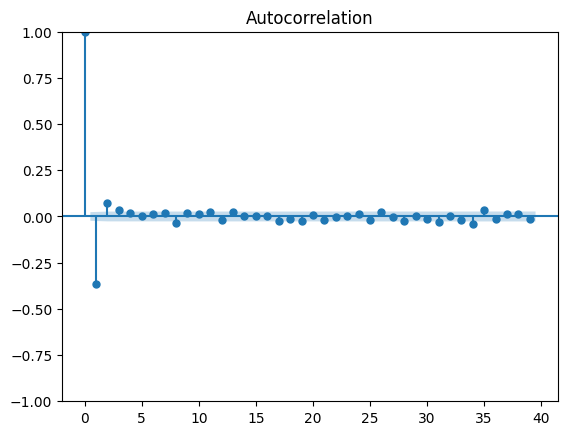

In [ ]:
acf_plot = plot_acf(arima_train.diff().dropna()) # autocorrelation plot using training data

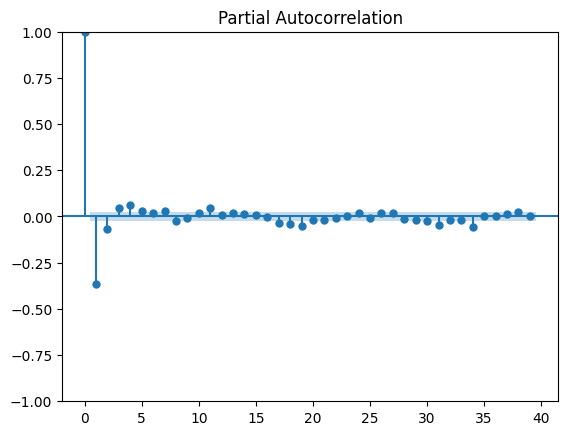

In [ ]:
pacf_plot = plot_pacf(arima_train.diff().dropna()) # partial autocorrelation plot on training data

Based on this plot, we can see that 1 is significant, so p will equal 1.

Based on the acf_plot, it appears to tail off at 2, so we will use 2 for q.

Our parameters for now will be 1,2,1.

### Auto Arima

There's a cool function called auto_arima that is a statistical algorithm for determining the optimal parameters for ARIMA.

Running this code might take a minute.

In [ ]:
import pmdarima as pm # importing the package

auto_arima = pm.auto_arima(arima_train, stepwise = False, seasonal = False) # using auto arima on the training data

auto_arima # printing variable

ARIMA(order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

Based on these results, the optimal parameters are 1,1,2 (we were close!). We'll use that instead when building out our ARIMA model.

## Building the Model

Below we use this code to build and print out the predicted and expected wave heights for the test.

This code might take a couple of minutes.

In [ ]:
waveheight_values = arima_data.WVHT
history = [x for x in arima_train]
predictions = list()
for t in range(len(arima_test)):
  model = ARIMA(history, order=(1,1,2)) # input the paramaters here within order=()
  model_fit = model.fit()
  output = model_fit.forecast()
  yhat = output[0]
  predictions.append(yhat)
  obs = arima_test[t]
  history.append(obs)
  print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3.121223, expected=3.120000
predicted=3.120443, expected=3.070000
predicted=3.089651, expected=2.890000
predicted=2.963137, expected=3.070000
predicted=3.005324, expected=2.960000
predicted=2.977777, expected=3.130000
predicted=3.065660, expected=3.020000
predicted=3.051192, expected=3.210000
predicted=3.149351, expected=3.340000
predicted=3.282153, expected=3.420000
predicted=3.393427, expected=3.230000
predicted=3.321176, expected=3.250000
predicted=3.274189, expected=3.340000
predicted=3.305211, expected=3.090000
predicted=3.176839, expected=3.070000
predicted=3.091155, expected=2.850000
predicted=2.923807, expected=2.880000
predicted=2.862735, expected=2.760000
predicted=2.779439, expected=2.900000
predicted=2.832422, expected=2.890000
predicted=2.870122, expected=2.910000
predicted=2.901523, expected=2.980000
predicted=2.956689, expected=2.880000
predicted=2.921602, expected=2.980000
predicted=2.954715, expected=2.750000
predicted=2.835125, expected=2.760000
predicted=2.

## Visualization

After the model completes its forecast, create a plot to visualize the difference between the predicted values and expected vales for wave heights.

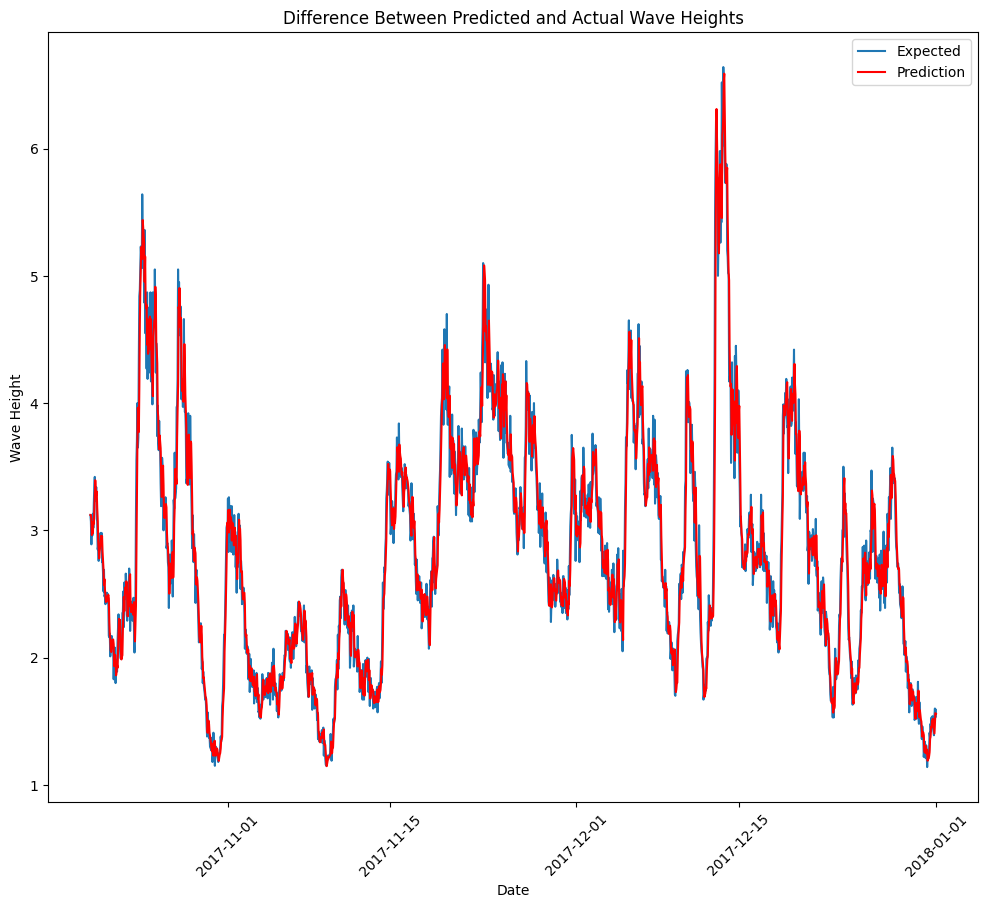

In [ ]:
test_x = arima_test.index # creating an index variable so that it's the dates

plt.figure (figsize=(12,10)) # setting up the plot size

plt.plot(test_x, arima_test, label='Expected') # plotting expected values
plt.plot(test_x, predictions, color='red', label='Prediction') # plotting predicted values
plt.xlabel('Date')
plt.ylabel('Wave Height')
plt.title('Difference Between Predicted and Actual Wave Heights')
plt.legend() # adding a legend to the plot

plt.xticks(rotation=45) # rotating the x labels for better visualization

plt.show()

## Model Evaluation

In machine learning, there are different ways to evaluate how well your model performed depending on what type of model you use.

For this project, we'll use mean absolute error and root squared value to determine how well our model did.

You can review this [resource](https://www.analyticsvidhya.com/blog/2021/10/evaluation-metric-for-regression-models/) to understand the metrics better.

In [ ]:
mae = mean_absolute_error(arima_test, predictions) # calculating mean absolute error
r_sq = r2_score(arima_test, predictions) # calculating root squared value
print('Test MAE: ', mae)
print('Test R^2: ', r_sq)

Test MAE:  0.1543645059115598
Test R^2:  0.9478662266840074


Based on these results and the visualization, this model did pretty good!

## Forecasting Values for the Future

Now that we've fitted, trained, tested, and evaluated our model, let's try to forecast future values.

Resource:
https://www.analyticsvidhya.com/blog/2020/10/how-to-create-an-arima-model-for-time-series-forecasting-in-python/


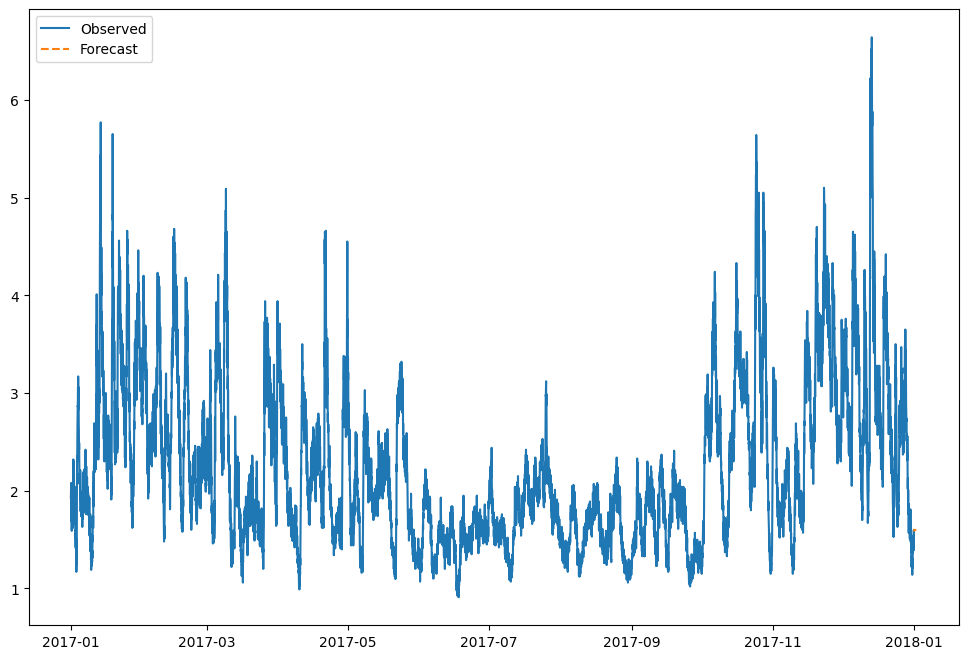

In [ ]:
# Extending the model to predict future values beyond the test set
future_predictions = list()
future_periods = 144  # Number of future periods to forecast, e.g., 144 intervals for 24 hours if each interval is 10 minutes
# Using the model to predict future values
for t in range(future_periods):
    model = ARIMA(history, order=(1, 1, 2))  # Adjust the order parameters as needed
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    future_predictions.append(yhat)
    history.append(yhat)  # Append the predicted value to history for the next prediction
# Creating future dates for the predictions
last_date = arima_data.index[-1]
future_dates = [last_date + pd.DateOffset(minutes=10 * (t + 1)) for t in range(future_periods)]
# Creating a DataFrame for the future predictions
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['forecast'])
# Plotting the results
import matplotlib.pyplot as plt
# Combining the original data with the future predictions for plotting
combined_df = pd.concat([arima_data, future_df])
plt.figure(figsize=(12, 8))
plt.plot(combined_df.index, combined_df['WVHT'], label='Observed')
plt.plot(future_df.index, future_df['forecast'], label='Forecast', linestyle='--')
plt.legend()
plt.show()

In [ ]:
model_fit.save('file')

In [1]:
from statsmodels.tsa.arima.model import ARIMAResults

results_ = ARIMAResults.load('file')

FileNotFoundError: [Errno 2] No such file or directory: 'file'

## Exploring Trends in Seasonality

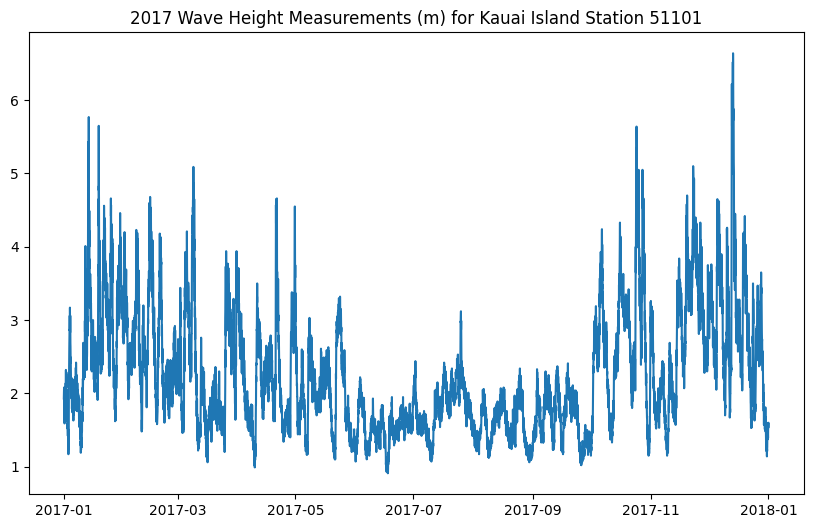

In [39]:
arima_data['WVHT'] = arima_data['WVHT'].astype(float) # changing the datatype for WVHT for a nicer look on the plot
plt.figure(figsize=(10,6)) # setting up the dimentions for our plot
plt.title('2017 Wave Height Measurements (m) for Kauai Island Station 51101') # setting up a title
plt.plot(arima_data['WVHT']) # plotting our data

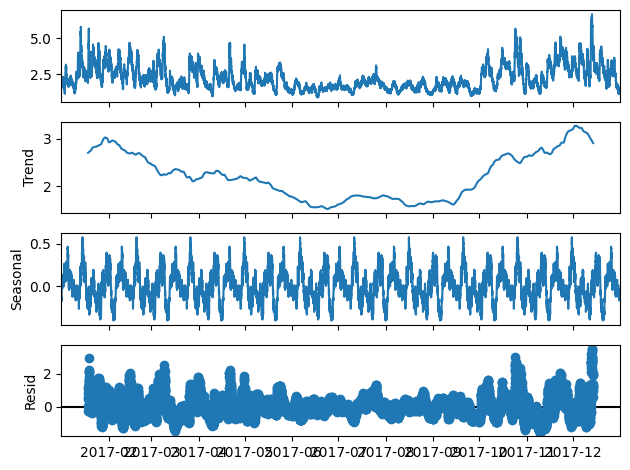

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(arima_data, model = 'additive', period = 840)

decomposition.plot()
plt.show()

<Figure size 1600x1000 with 0 Axes>

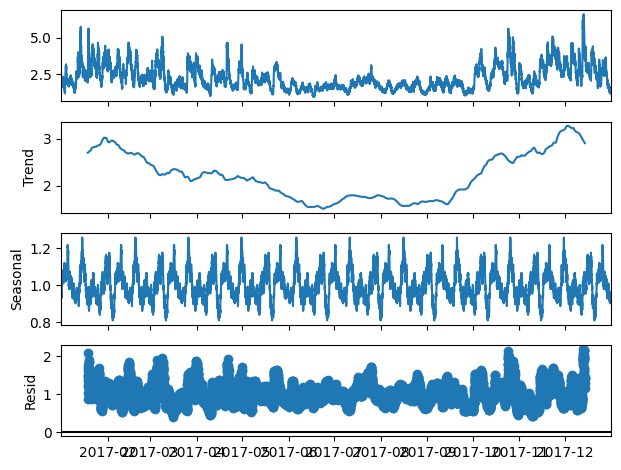

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(16, 10))
decomposition = seasonal_decompose(arima_data, model = 'multiplicative', period = 840)

decomposition.plot()
plt.show()

#Connecting to Git